# Time series Forecasting of 10 Year Treasury Rate variable.

### The 10 Year Treasury Rate is the yield received for investing in a US government issued treasury security that has a maturity of 10 year. The 10 year treasury yield is included on the longer end of the yield curve. Many analysts will use the 10 year yield as the "risk free" rate when valuing the markets or an individual security. Historically, the 10 Year treasury rate reached 15.84% in 1981 as the Fed raised benchmark rates in an effort to contain inflation.

### Accurate forecasting of the 10 Year Treasury Rate can provide critical insights to financial institutions, investors, policymakers, and other stakeholders for managing risk, optimizing investment strategies, and making informed decisions. In this paper, we propose a time series forecasting approach to predict the 10 Year Treasury Rate, leveraging historical data, statistical techniques, and machine learning algorithms. Here my goal is to develop a reliable and accurate model that can effectively forecast the 10 Year Treasury Rate, enabling stakeholders to anticipate changes in interest rates and adapt their financial strategies accordingly.

In [1]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime as dt

#arima
from pmdarima.arima import auto_arima, ADFTest
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Data 

In [2]:
# read the file
df = pd.read_excel('Time series input data.xlsx', header=None)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,225,226,227,228,229,230
0,Metric,Mnemonic,Definition of Quarter Ending Months,2004-01-28 00:00:00,2004-02-28 00:00:00,2004-03-28 00:00:00,2004-04-28 00:00:00,2004-05-28 00:00:00,2004-06-28 00:00:00,2004-07-28 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
1,Key Macroeconomic Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Real GDP,FGDP$_US,Quarterly,13555.213297,13580.006703,13606.51,13639.391319,13673.368681,13706.25,13748.228043,...,18932.77,18958.510659,18985.109341,19010.85,19038.231087,19065.612174,19092.11,19120.138043,19147.261956,19175.29
3,Unemployment Rate (National Level),FLBR_US,Quarterly Average,5.785714,5.744286,5.7,5.667033,5.632967,5.6,5.542717,...,4.19,4.193297,4.196703,4.2,4.210109,4.220217,4.23,4.23,4.23,4.23
4,HPI -All Transactions (National Level),FHOFHOPIQ_US,Quarterly,295.297692,297.082308,298.99,301.459231,304.010769,306.48,309.930435,...,429.99,431.196593,432.443407,433.65,434.980978,436.311957,437.6,439.055652,440.464348,441.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,Mortgage Rates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,3/1 Hybrid ARM,_3_1_ARM,NaN,3.44,3.25,3.15,3.87,4.12,4.27,4.1,...,5.095074,5.095074,5.095074,5.095074,5.095074,5.095074,5.095074,5.095074,5.095074,5.095074
501,5/1 Hybrid ARM,_5_1_ARM,NaN,4.13,3.95,3.86,4.55,4.8,4.88,4.65,...,4.662212,4.662212,4.662212,4.662212,4.662212,4.662212,4.662212,4.662212,4.662212,4.662212
502,7/1 Hybrid ARM,_7_1_ARM,NaN,4.71,4.48,4.35,4.95,5.26,5.36,5.13,...,4.600472,4.600472,4.600472,4.600472,4.600472,4.600472,4.600472,4.600472,4.600472,4.600472


In [4]:
#joining first three columns
cols = [0, 1, 2]
df['Column_Desc'] = df[cols].apply(lambda row: ' - '.join(row.values.astype(str)), axis=1)

#droping rows that are headings only
df.dropna(subset=[2], inplace=True)

# dropping first three columns
df.drop(cols, axis=1, inplace=True)

#making merged column as index so it wil be column names after transpose
df.set_index('Column_Desc', inplace=True)

# transpose it
df = df.transpose()

# Change the name Date column for our convenience
df.rename(columns={'Metric - Mnemonic - Definition of Quarter Ending Months':'Date',
                   '10-Year Treasury Rate  - FRGT10Y_US - End of Quarter Value':'Ten_Year_Treasury_rate'
                  }, inplace=True)

# drop the two columns that had null vlaues
df.drop(df.columns[df.isna().sum() > 0], axis =1,inplace=True )

#make data as the index of the new dataframe
df.set_index('Date', inplace=True)

In [5]:
ts_column = 'Ten_Year_Treasury_rate'
# Get the final dataframe for the column we want
ts_data = pd.DataFrame(pd.to_numeric(df[ts_column]) )

In [6]:
ts_data.head()

,Ten_Year_Treasury_rate
Date,
2004-01-28,4.18
2004-02-28,3.99
2004-03-28,3.86
2004-04-28,4.53
2004-05-28,4.70


<AxesSubplot:xlabel='Date'>

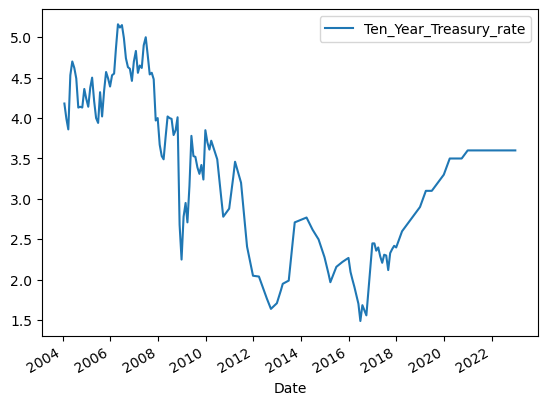

In [7]:
ts_data.plot()

## ADF Test

In [8]:
adf_test = ADFTest(alpha=.05)
adf_test.should_diff(ts_data)

(0.9397775268713375, True)

* Failed to reject the null hypothesis. The TS is non-stationary.

## Differencing

In [9]:
#initialize differencing value
d_val = 0

for i in range(1,20):
    ts_data['diff1'] = ts_data[ts_column].diff(i)
    adf_test = ADFTest(alpha=.05)
    result = adf_test.should_diff(ts_data.diff1[i:])
    print(result[0],result[1])
    if not result[1]:
        d_val = i
        break
print('differencing_value:',d_val)

0.01 False
differencing_value: 1


In [10]:
#Differencing works. Remove the first row
ts_data = ts_data.dropna()

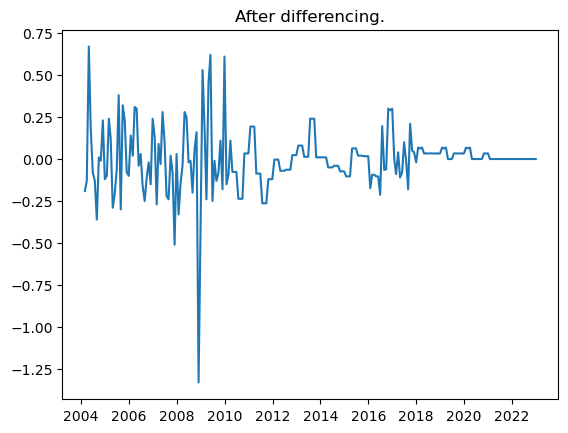

In [11]:
plt.plot(ts_data['diff1'])
plt.title('After differencing.')
plt.show()

In [12]:
# for final output comparison from different models, create a dataframe
finalResults = pd.DataFrame(columns=['Model','MAPE','RMSE'])

## Train-Test split

In [13]:
#splitting
ts_train = ts_data[ts_data.index < '2017-06-01']
ts_oot = ts_data[(ts_data.index > '2017-06-01') & (ts_data.index < '2019-01-01')]
ts_test = ts_data[ts_data.index > '2019-01-01']

y_train = ts_train[ts_column]
y_oot = ts_oot[ts_column]
y_test = ts_test[ts_column]

## ACF - PACF Plots

F:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


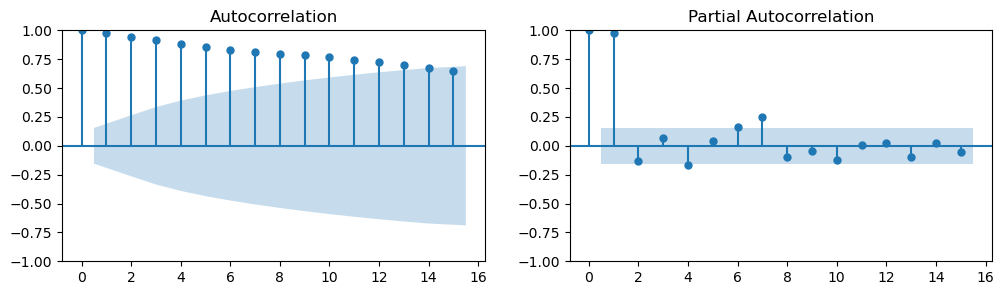

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
plot_acf(y_train.squeeze(), lags=15, ax=ax[0])
plot_pacf(y_train.squeeze(), lags=15, ax=ax[1])
plt.show()

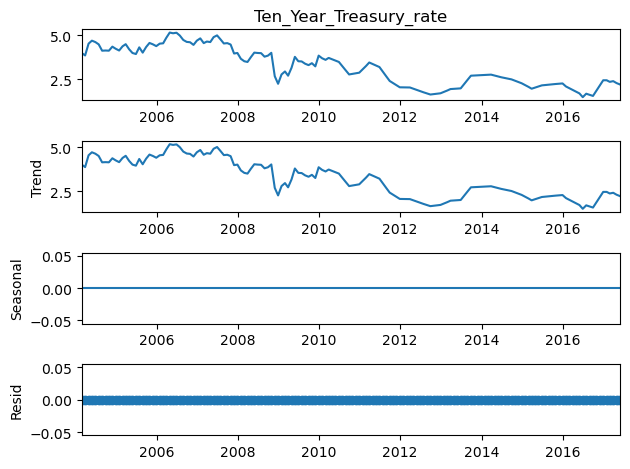

In [15]:
# seasonal decomposition
result = seasonal_decompose(y_train, model='additive', period=1)
result.plot()
plt.show()

In [16]:
# From the above we get that 
p_val = 1
q_val = 11

## Models

In [17]:
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [18]:
# Creating a generic function to run arima for different p,d,q,P,D,Q for a train and test data series passed.

def arimaFunc(y_train,y_oot,p,d,q,P,D,Q,s):
    model = ARIMA(y_train, order=(p,d,q) , seasonal_order=(P,D,Q,s)).fit()
    y_hat_temp = model.forecast(steps=len(y_oot))
    vl_rmse = np.sqrt(mean_squared_error(y_hat_temp,y_oot))
    vl_mape = mean_absolute_percentage_error(y_hat_temp,y_oot)
    print('RMSE: ',vl_rmse)
    print('MAPE: ',vl_mape)

    # oot dataframe
    y_hat = pd.DataFrame(y_hat_temp)
    y_hat.index = y_oot.index
    
    #add to result dataset
    model_name = 'ARIMA(' + str(p)+','+ str(d)+','+str(q)+')('+str(P)+','+ str(D)+','+str(Q)+')['+str(s)+']'
    finalResults.loc[len(finalResults),:] = [model_name,vl_mape,vl_rmse]

    # plotting prediction along with actual
    plt.plot(pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_oot)]), label = 'Actual '+str(ts_column))
    plt.plot(y_hat, label = 'Predicted '+str(ts_column))
    plt.legend(loc = 'best')
    plt.title(model_name)
    plt.show()

## AR(p) model

RMSE:  0.21512867321934814
MAPE:  0.07665515935867902


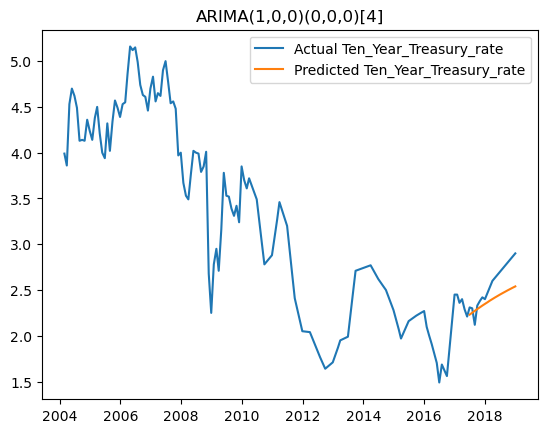

In [19]:
arimaFunc(y_train,y_oot,p=p_val,d=0,q=0,P=0,D=0,Q=0,s=4)

## MA(q) model

RMSE:  0.3748595659863621
MAPE:  0.11723855034739734


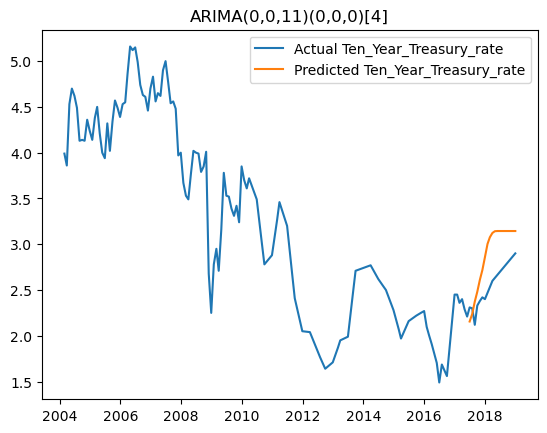

In [20]:
arimaFunc(y_train,y_oot,p=0,d=0,q=q_val,P=0,D=0,Q=0,s=4)

## ARMA(p,q) model

RMSE:  0.19955977626260063
MAPE:  0.0682766342650096


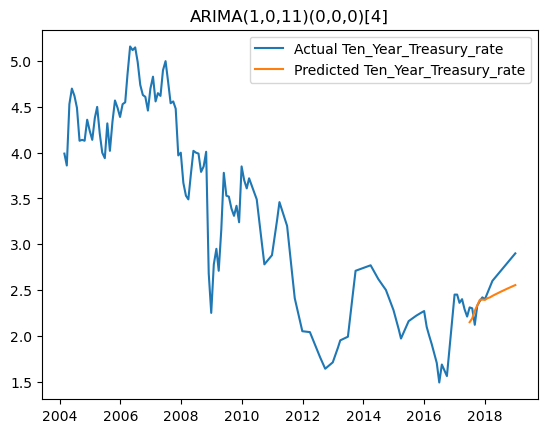

In [21]:
arimaFunc(y_train,y_oot,p=p_val,d=0,q=q_val,P=0,D=0,Q=0,s=4)

## ARIMA (p,d,q) model

RMSE:  0.4105091209514547
MAPE:  0.1628537184150641


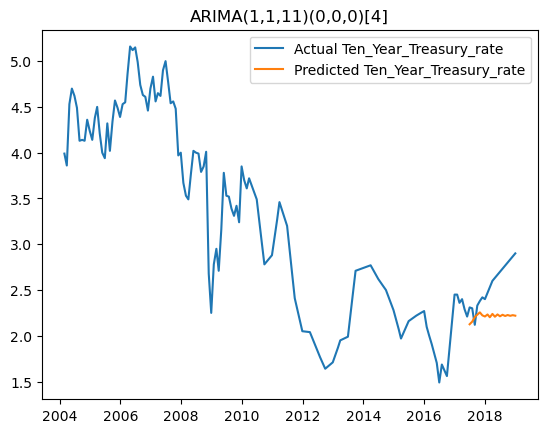

In [22]:
arimaFunc(y_train,y_oot,p=p_val,d=d_val,q=q_val,P=0,D=0,Q=0,s=4)

## AUTO ARIMA

In [23]:
from pmdarima.arima import auto_arima, ADFTest
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(y_train, start_p=1, max_p=3, start_q=1, max_q=15,
                          m = 4, start_P = 0, max_P=5,
                          start_Q = 0, max_Q = 7,
                          seasonal = True,
                          d= 2, D = None, trace = True, 
                          error_action ='ignore', 
                          # we don't want to know if an order does not work 
                          suppress_warnings = True, 
                          # we don't want convergence warnings
                          information_criterion='aic',
                          stepwise = True) # set to stepwise 

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=53.986, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=34.514, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=34.753, Time=0.05 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=36.508, Time=0.11 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=36.381, Time=0.17 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=34.511, Time=0.13 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=36.499, Time=0.12 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=38.253, Time=0.26 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=55.542, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=1.178, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=-0.186, Time=0.07 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=1.142, Time=0.08 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=3.139, Time=0.20 sec
 ARIMA

RMSE:  0.5168782385169419
MAPE:  0.21477749633481028


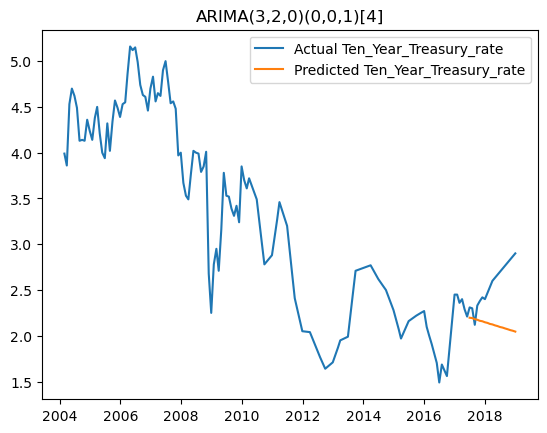

In [24]:
arimaFunc(y_train,y_oot,p=3,d=2,q=0,P=0,D=0,Q=1,s=4)

RMSE:  0.11158398997760613
MAPE:  0.040568082914159094


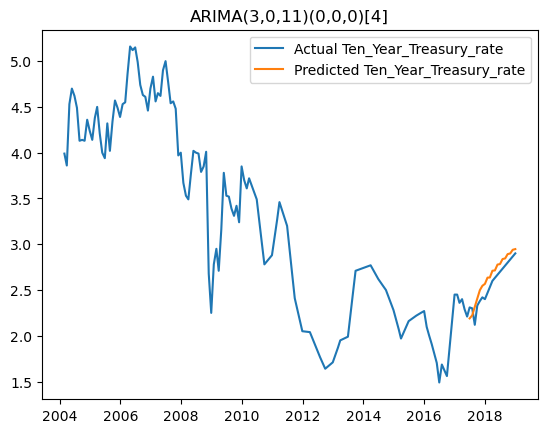

In [25]:
arimaFunc(y_train,y_oot,p=3,d=0,q=11,P=0,D=0,Q=0,s=4)

## Exponential smoothing models

In [26]:
def expSmoothResults(name,y_hat,y_oot):
    #prediction's metrics
    tes_rmse_out = np.sqrt(mean_squared_error(y_hat, y_oot))
    tes_mape_out = mean_absolute_percentage_error(y_hat, y_oot)
    print('RMSE: ', tes_rmse_out)
    print('MAPE: ', tes_mape_out)

    # oot dataframe
    y_hat = pd.DataFrame(y_hat)
    y_hat.index = y_oot.index

    #add to result dataset
    model_name = name
    finalResults.loc[len(finalResults),:] = [model_name,tes_mape_out,tes_rmse_out]

    # plotting prediction along with actual
    plt.plot(pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_oot)]), label = 'Actual '+str(ts_column))
    plt.plot(y_hat, label = 'Predicted '+str(ts_column))
    plt.legend(loc = 'best')
    plt.title(model_name)
    plt.show() 

### SES

RMSE:  0.4185620710449959
MAPE:  0.1655414854961882


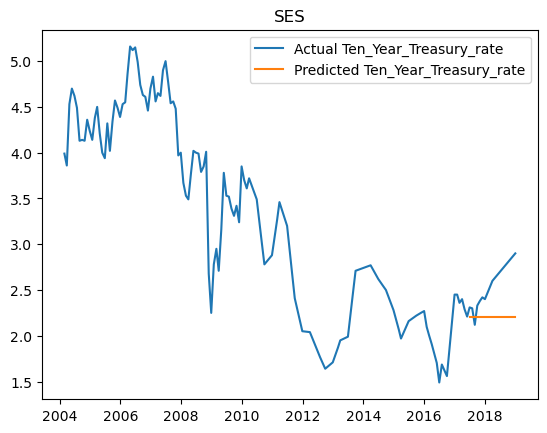

In [27]:
fit_ses = SimpleExpSmoothing(y_train).fit(optimized=True)
y_hat = fit_ses.forecast(len(y_oot))

expSmoothResults('SES',y_hat,y_oot)

### DES

RMSE:  0.5454443662752099
MAPE:  0.2299830425821904


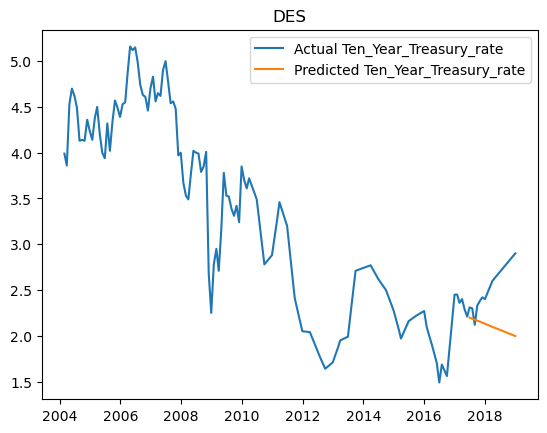

In [28]:
fit_des = Holt(y_train).fit(optimized=True)
y_hat = fit_des.forecast(len(y_oot))

expSmoothResults('DES',y_hat,y_oot)

### TES

RMSE:  0.5509820832661735
MAPE:  0.2330947278771874


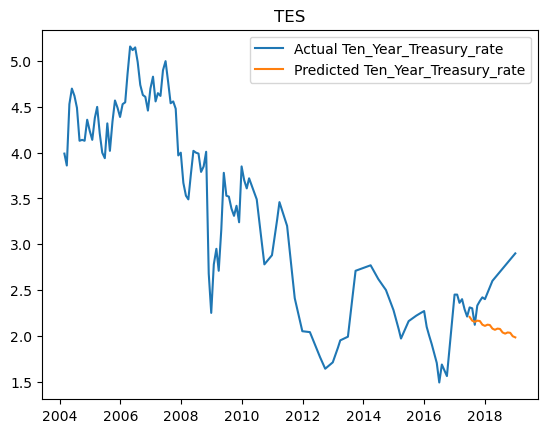

In [29]:
fit_tes = ExponentialSmoothing(y_train,seasonal_periods=4, trend='mul', seasonal='mul').fit(optimized=True)
y_hat = fit_tes.forecast(len(y_oot))

expSmoothResults('TES',y_hat,y_oot)

## Final results

In [30]:
finalResults

,Model,MAPE,RMSE
0,"ARIMA(1,0,0)(0,0,0)[4]",0.076655,0.215129
1,"ARIMA(0,0,11)(0,0,0)[4]",0.117239,0.37486
2,"ARIMA(1,0,11)(0,0,0)[4]",0.068277,0.19956
3,"ARIMA(1,1,11)(0,0,0)[4]",0.162854,0.410509
4,"ARIMA(3,2,0)(0,0,1)[4]",0.214777,0.516878
5,"ARIMA(3,0,11)(0,0,0)[4]",0.040568,0.111584
6,SES,0.165541,0.418562
7,DES,0.229983,0.545444
8,TES,0.233095,0.550982


* The best models obtained are ARIMA(1,0,11)(0,0,0)[4]	and ARIMA(3,0,11)(0,0,0)[4] based on MAPE and RMSE scores. Choosing the second one for final forecasting.

# Final model 

In [31]:
y_train_final = pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_oot)])

RMSE:  0.2720294625484805
MAPE:  0.07821659586910445


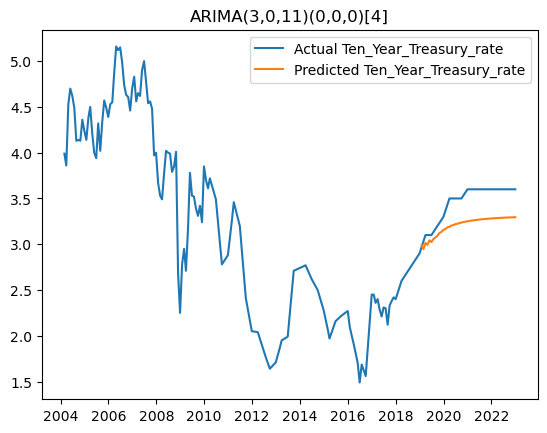

In [32]:
arimaFunc(y_train_final,y_test,p=3,d=0,q=11,P=0,D=0,Q=0,s=4)

#### We've received MAPE at 7.8% and RMSE 0.27 with our final model.